In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import DarkNews as dn

# Our module
import nuflux

In [2]:
# SANITY CHECK
Radius = 1e6
Detector_height = 1e3
Dimensions_detector = [3e2, 0]

mdb = nuflux.fluxMC.MuonDecay()

df = mdb.simulate_decays(
                            pmin = 0, #minimum momentum
                            pmax = 3e3,  #maximum momentum
                            beam_p0 = 1e3, # average momentum (GeV)
                            beam_dpop = 0.1,# little beam spread
                            Rpm=0.5, #Fraction of total muons that are plus (or minus?)
                            NINT=10, #for MC integration
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )

_= mdb.propagate_to_detector(
                            Racc = Radius,
                            circular = True,
                            det_height = Detector_height, #10 m in cm
                            Ddetector =Dimensions_detector) #arbitrary dimensions for circ detect SHEET at x = 0, y=0, z = Racc ; [0] is radius of detector and [1] is the hollow hole in the middle 
_ = mdb.flux_in_detector(circular = True, NBINS=50)

print("If decay uniform, then acceptance = {:.2e}".format(1 / 2 /np.pi * np.arccos(Radius / (Radius + Dimensions_detector[0]))))

187431
Detector acceptance: 4.08e-03 for nue and 4.08e-03 for numu
If decay uniform, then acceptance = 3.90e-03


In [3]:
# CROSS SECTIONS
from scipy import interpolate

log10E,sigmae,sigmamu,_,sigmaebar,sigmamubar,_ = np.genfromtxt('xsecs/XCC.dat',unpack=True)
exs = 10**(log10E)
sigmanue = interpolate.interp1d(exs,sigmae*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanuebar = interpolate.interp1d(exs,sigmaebar*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumu = interpolate.interp1d(exs,sigmamu*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumubar = interpolate.interp1d(exs,sigmamubar*exs*1e-38,bounds_error=False,fill_value=0.0)

In [4]:
# APPROXIMATION FOR EVENT RATES
Nmu = 1e18
rho = 1.5 #g/cm**3
mn = 939e6 *1.6e-19/(3e8)**2 * 10**3 #g
Ntargets= rho /mn #1/cm**3
h= 10e2 #cm
deltaE_nue = mdb.Enue_ND[1] -mdb.Enue_ND[0]
deltaE_numu = mdb.Enumu_ND[1] - mdb.Enumu_ND[0]
epsilon_nue = mdb.flux_nue_ND_p/np.sum(mdb.flux_nue_ND_p) / deltaE_nue
epsilon_numu = mdb.flux_numu_ND_p/np.sum(mdb.flux_numu_ND_p) / deltaE_numu

dNnue_dE = epsilon_nue * Ntargets*Nmu * mdb.nue_eff_ND * h * sigmanue(mdb.Enue_ND) # Should multpliy by acceptance
dNnumu_dE= epsilon_numu * Ntargets *h*Nmu * mdb.numu_eff_ND * sigmanumubar(mdb.Enumu_ND)
print(round(sum(dNnue_dE) * (mdb.Enue_ND[1] - mdb.Enue_ND[0])))
print(round(sum(dNnumu_dE) * (mdb.Enumu_ND[1] - mdb.Enumu_ND[0])))

6670465
4069965


nue interaction count (ray tracing): 6667239, vs. approximate: 6670465
numu interaction count (ray tracing): 4030734, vs. approximate 4069965


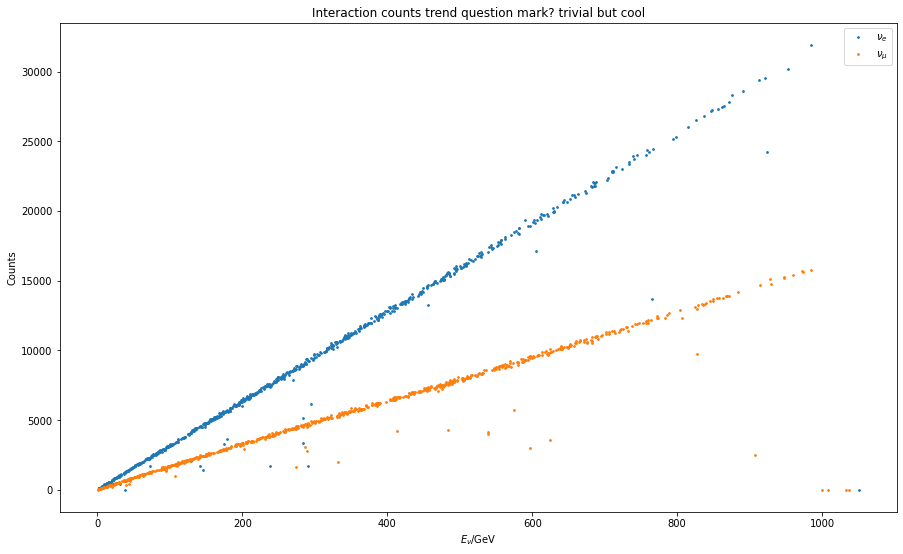

In [5]:
#ACTUAL EVENT NUMBER FROM RAY TRACING
from scipy.stats import binom
na_numu = np.sum(mdb.mask_numu)
na_nue = np.sum(mdb.mask_nue)
factors_numu = np.full((1, na_numu),round(Nmu / mdb.sample_size))
factors_nue = np.full((1, na_nue), round(Nmu / mdb.sample_size))
earg_numu = - 1 * Ntargets * mdb.heights[:, 1][mdb.mask_numu] * sigmanumubar(mdb.Enumu)[mdb.mask_numu]
earg_nue = - 1 * Ntargets * mdb.heights[:, 1][mdb.mask_nue] * sigmanue(mdb.Enue)[mdb.mask_nue]
p_ints_numu = 1 - np.exp( earg_numu)
p_ints_nue = 1 - np.exp( earg_nue)
count_nue = binom.rvs(factors_nue, p_ints_nue)
print("nue interaction count (ray tracing): {}, vs. approximate: {}".format(sum(count_nue), round(sum(dNnue_dE) * (mdb.Enue_ND[1] - mdb.Enue_ND[0]))))
count_numu = binom.rvs(factors_numu, p_ints_numu)
print("numu interaction count (ray tracing): {}, vs. approximate {}".format(sum(count_numu), round(sum(dNnumu_dE) * (mdb.Enumu_ND[1] - mdb.Enumu_ND[0]))))
fig = plt.figure(figsize=(15,9))
plt.title("Interaction counts trend question mark? trivial but cool")
plt.ylabel("Counts")
plt.xlabel(r"$E_{\nu}/$GeV")
plt.scatter(mdb.Enue[mdb.mask_nue], count_nue, s= 3, label=r'$\nu_e$')
plt.scatter(mdb.Enumu[mdb.mask_numu], count_numu, s = 3, label =r'$\nu_{\mu}$')
plt.legend(loc = 'best')

/tmp/ipykernel_1829/1595791162.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_bins[0, i] = sum(count_nue[mask_nue])
/tmp/ipykernel_1829/1595791162.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_bins[1, i] = sum(count_numu[mask_numu])


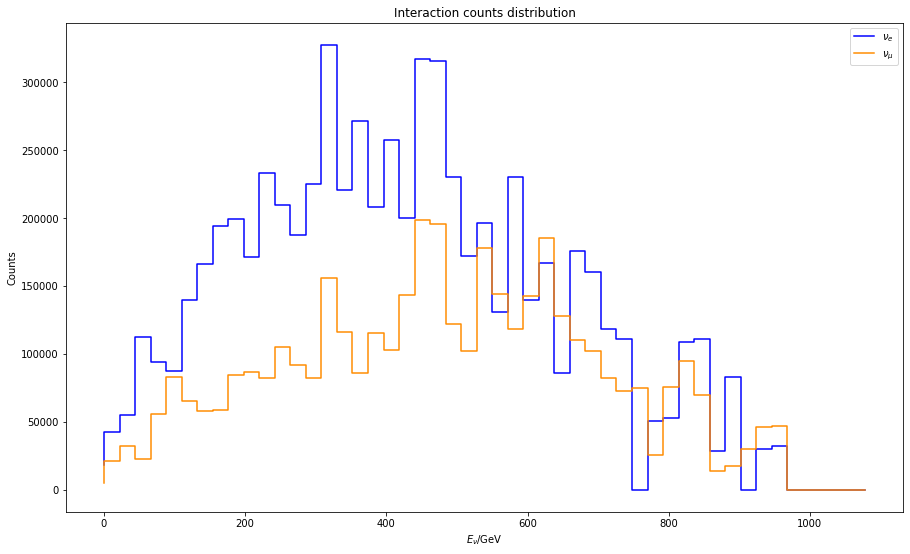

In [6]:
#Convert data to histogram
bins = 50
max_E =np.max(np.concatenate((mdb.Enumu[mdb.mask_numu], mdb.Enue[mdb.mask_nue])))
bin_size = round(max_E / bins) + 1
e_bins = np.empty((2, bins))
for i in range(50):
    mask_nue = [(mdb.Enue[mdb.mask_nue] > i *bin_size) & (mdb.Enue[mdb.mask_nue] <= (i+1) *bin_size)]
    e_bins[0, i] = sum(count_nue[mask_nue])
    mask_numu = [(mdb.Enumu[mdb.mask_numu] > i *bin_size) & (mdb.Enumu[mdb.mask_numu] <= (i+1) *bin_size)]
    e_bins[1, i] = sum(count_numu[mask_numu])
fig = plt.figure(figsize=(15,9))
plt.title("Interaction counts distribution")
plt.step([i*bin_size for i in range(50)], e_bins[0,:], label =r'$\nu_{e}$', color = 'blue')
plt.step([i*bin_size for i in range(50)], e_bins[1,:], label =r'$\nu_{\mu}$', color = 'darkorange')
plt.ylabel("Counts")
plt.xlabel(r"$E_{\nu}/$GeV")
plt.legend()

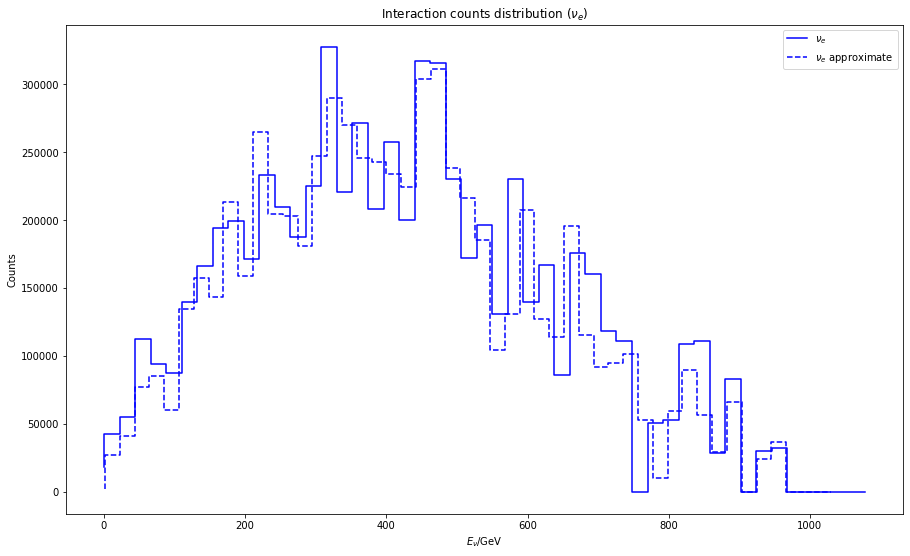

In [7]:
fig = plt.figure(figsize=(15,9))
plt.title(r"Interaction counts distribution ($\nu_{e}$)")
plt.step([i*bin_size for i in range(50)], e_bins[0,:], label =r'$\nu_{e}$', color = 'blue')
plt.step(mdb.Enue_ND,dNnue_dE*(mdb.Enue_ND[1] - mdb.Enue_ND[0]), label=r'$\nu_{e}$ approximate', linestyle = '--', color = 'blue')
plt.ylabel("Counts")
plt.xlabel(r"$E_{\nu}/$GeV")
plt.legend()

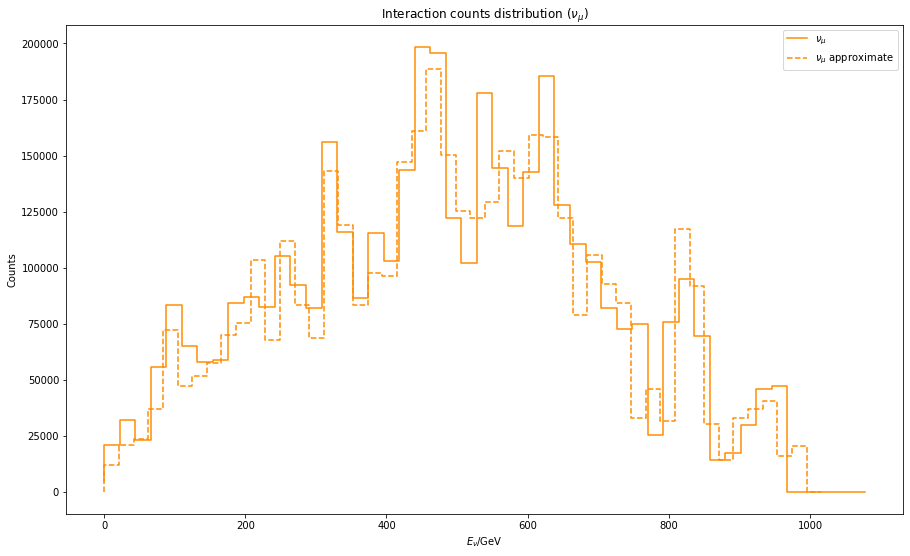

In [8]:
fig = plt.figure(figsize=(15,9))
plt.title(r"Interaction counts distribution ($\nu_{\mu}$)")
plt.step([i*bin_size for i in range(50)], e_bins[1,:], label =r'$\nu_{\mu}$', color = 'darkorange')
plt.step(mdb.Enumu_ND,dNnumu_dE*(mdb.Enumu_ND[1] - mdb.Enumu_ND[0]), label=r'$\nu_{\mu}$ approximate', linestyle = '--', color = 'darkorange')
plt.ylabel("Counts")
plt.xlabel(r"$E_{\nu}/$GeV")
plt.legend()

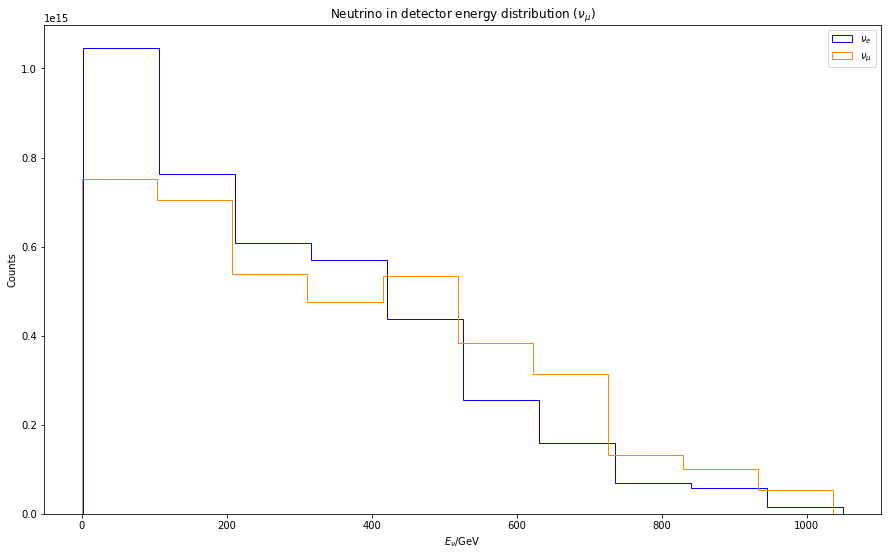

In [9]:
fig = plt.figure(figsize=(15,9))
plt.title(r"Neutrino in detector energy distribution ($\nu_{\mu}$)")
plt.ylabel("Counts")
plt.xlabel(r"$E_{\nu}/$GeV")
plt.hist(mdb.Enue[mdb.mask_nue], weights = np.full((len(mdb.Enue[mdb.mask_nue])), round(Nmu / mdb.sample_size)), histtype ='step', label =r'$\nu_{e}$', color = 'blue')
plt.hist(mdb.Enumu[mdb.mask_numu], weights = np.full((len(mdb.Enumu[mdb.mask_numu])), round(Nmu / mdb.sample_size)), histtype = 'step', label =r'$\nu_{\mu}$', color = 'darkorange')
plt.legend()

187534
Detector acceptance: 3.80e-03 for nue and 3.83e-03 for numu
If decay uniform, then acceptance = 3.90e-03
nue interaction count (ray tracing): 6576861, vs. approximate: 6637406
numu interaction count (ray tracing): 3650522, vs. approximate 3699506






/home/luc/Research/BIN_MC/nuflux/data.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask_numu = [(mdb.Enumu[mdb.mask_numu] > i *bin_size) & (mdb.Enumu[mdb.mask_numu] <= (i+1) *bin_size)]
/home/luc/Research/BIN_MC/nuflux/data.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<Figure size 432x288 with 0 Axes>

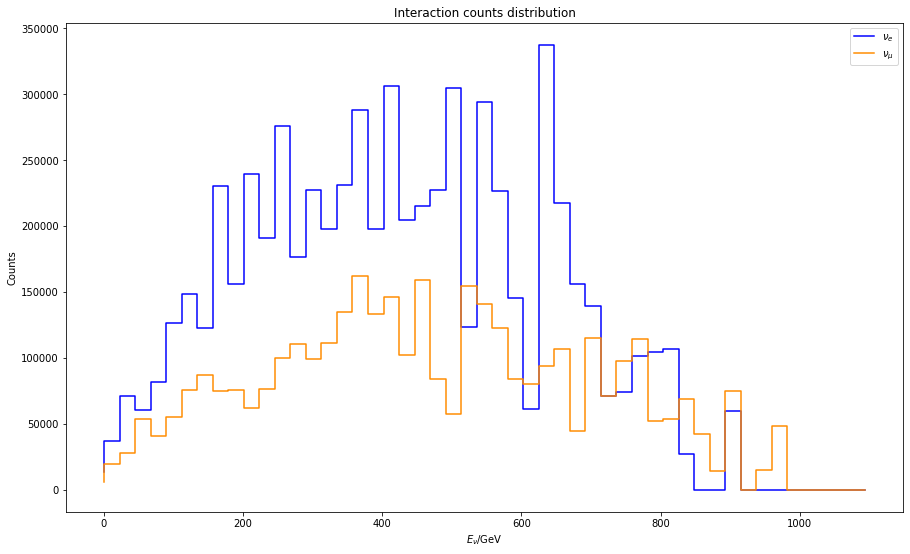

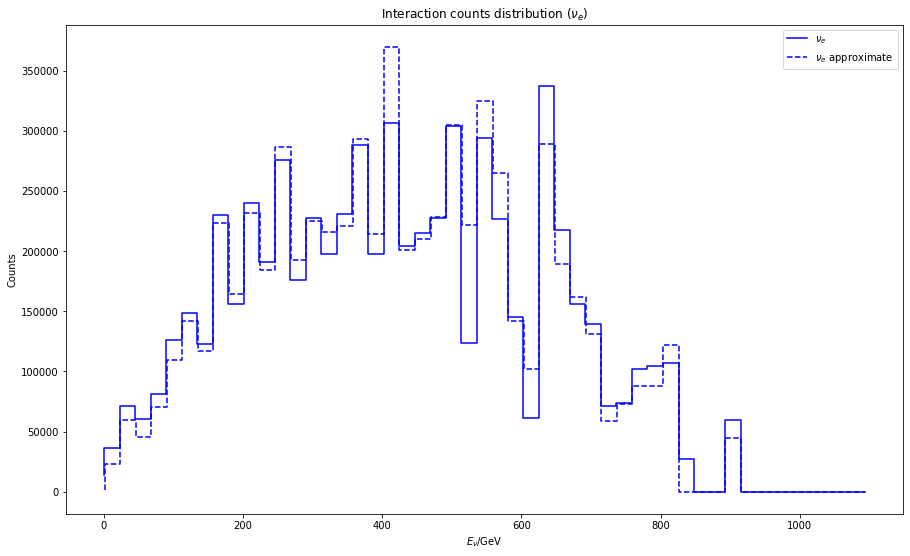

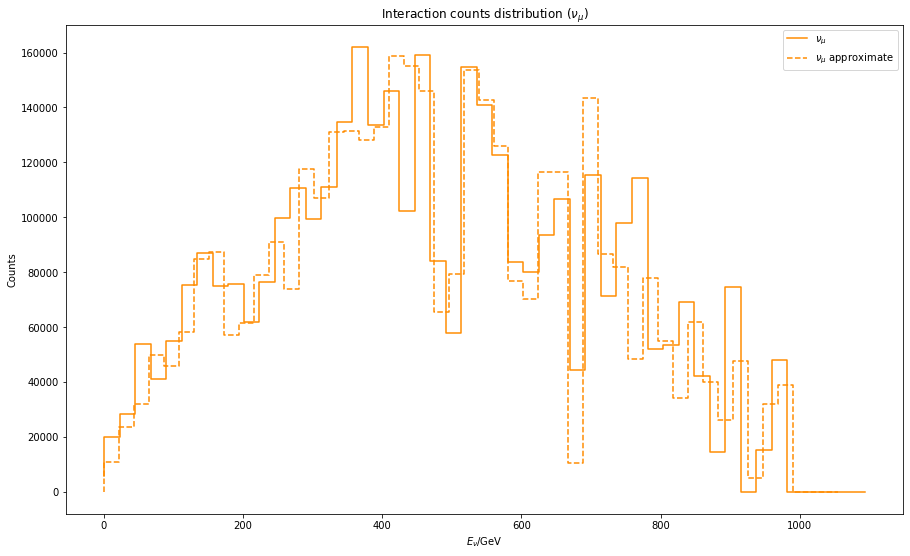

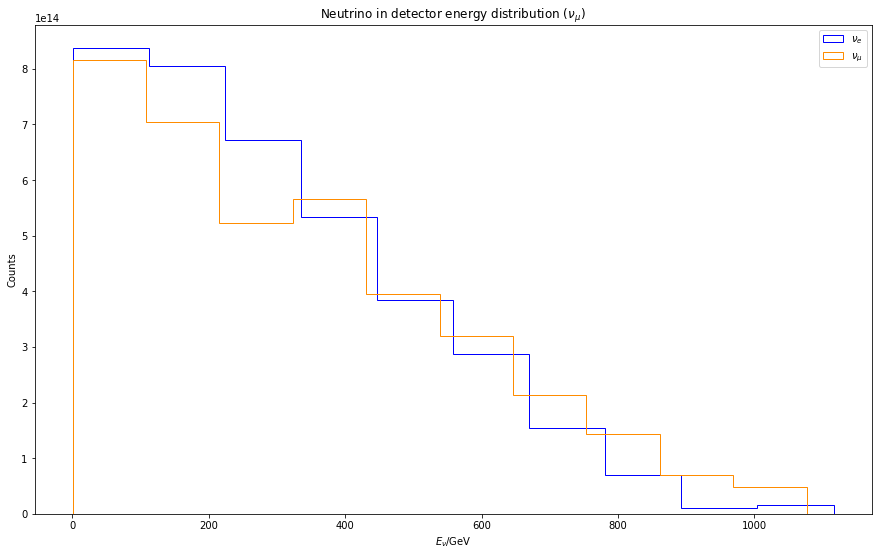

In [27]:
from nuflux import data
data.show_events(p0 = 1e3, p_max = 3e3, p_min = 0, RA =1e6, DH = 1e3, DD = [3e2,0], Nmu = 1e18, rho = 1.5, plots = True)

187523
Detector acceptance: 4.10e-03 for nue and 4.10e-03 for numu
If decay uniform, then acceptance = 3.90e-03
nue interaction count (ray tracing): 2678128, vs. approximate: 2113370
numu interaction count (ray tracing): 1094200, vs. approximate 1121423






/home/luc/Research/BIN_MC/nuflux/data.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask_numu = [(mdb.Enumu[mdb.mask_numu] > i *bin_size) & (mdb.Enumu[mdb.mask_numu] <= (i+1) *bin_size)]
/home/luc/Research/BIN_MC/nuflux/data.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<Figure size 432x288 with 0 Axes>

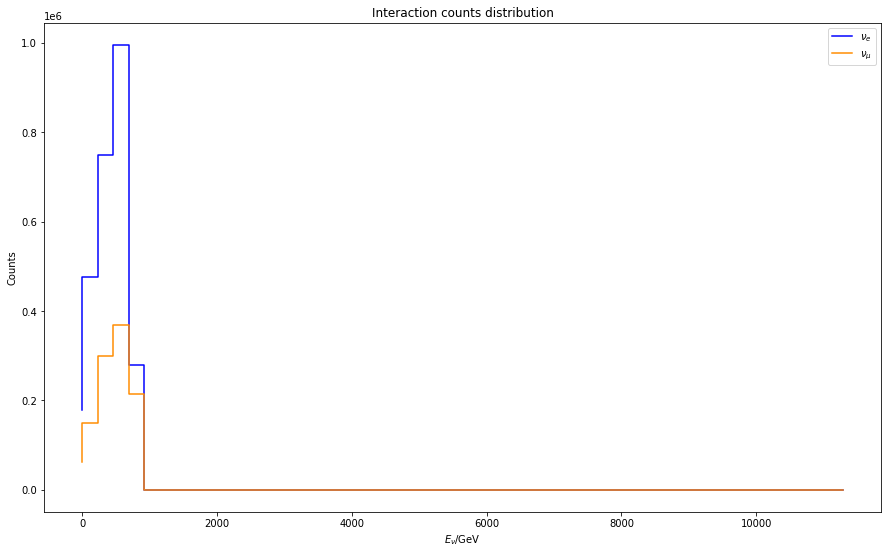

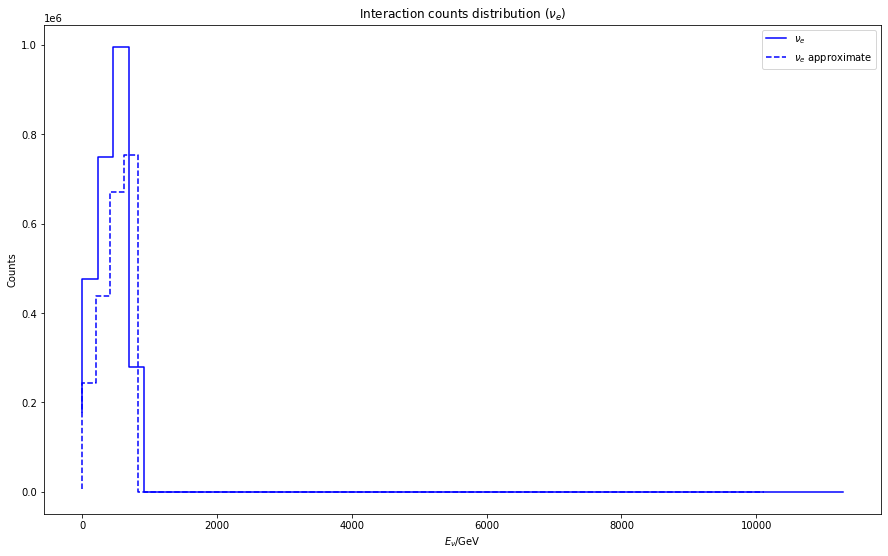

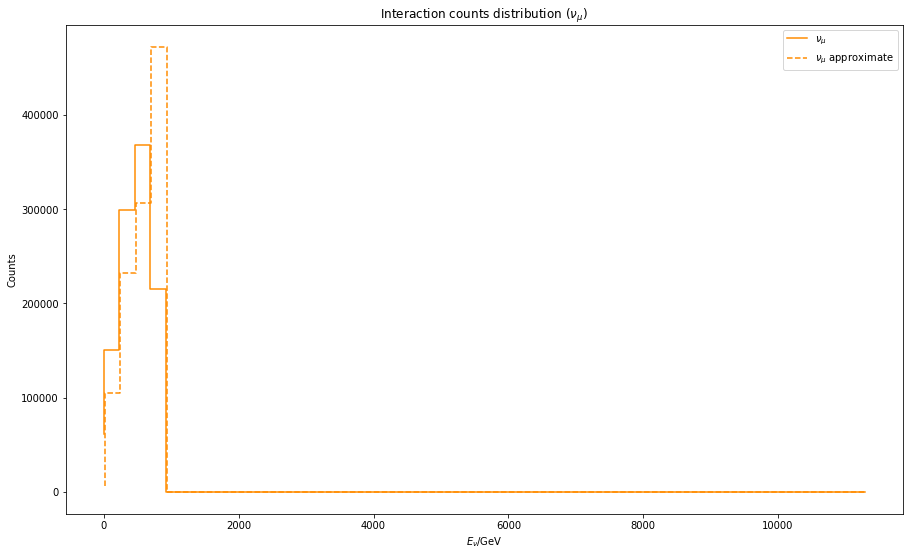

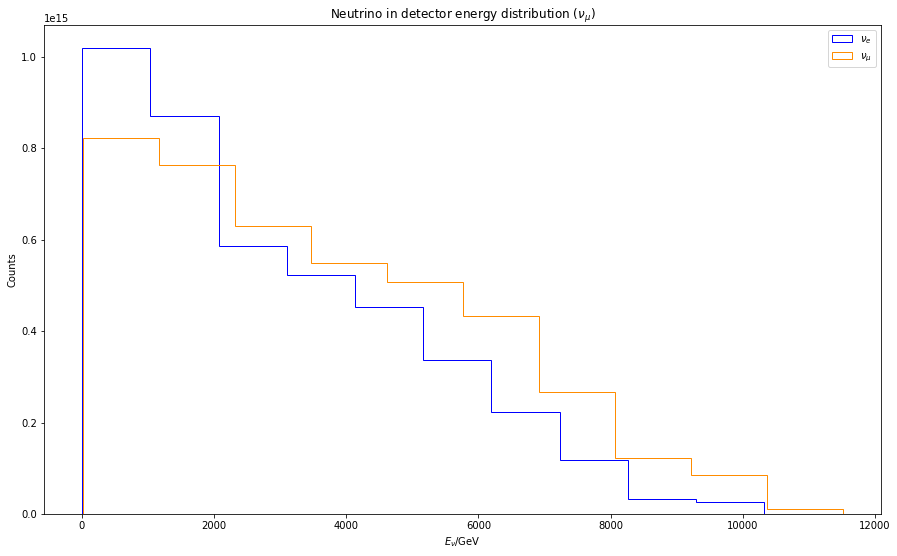

In [28]:
from nuflux import data
data.show_events(p0 = 1e4, p_max = 3e4, p_min = 0, RA =1e6, DH = 1e3, DD = [3e2,0], Nmu = 1e18, rho = 1.5, plots = True)

187484
Detector acceptance: 3.66e-03 for nue and 3.67e-03 for numu
If decay uniform, then acceptance = 3.90e-03
nue interaction count (ray tracing): 642284, vs. approximate: 651292
numu interaction count (ray tracing): 416160, vs. approximate 405632






/home/luc/Research/BIN_MC/nuflux/data.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask_numu = [(mdb.Enumu[mdb.mask_numu] > i *bin_size) & (mdb.Enumu[mdb.mask_numu] <= (i+1) *bin_size)]
/home/luc/Research/BIN_MC/nuflux/data.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<Figure size 432x288 with 0 Axes>

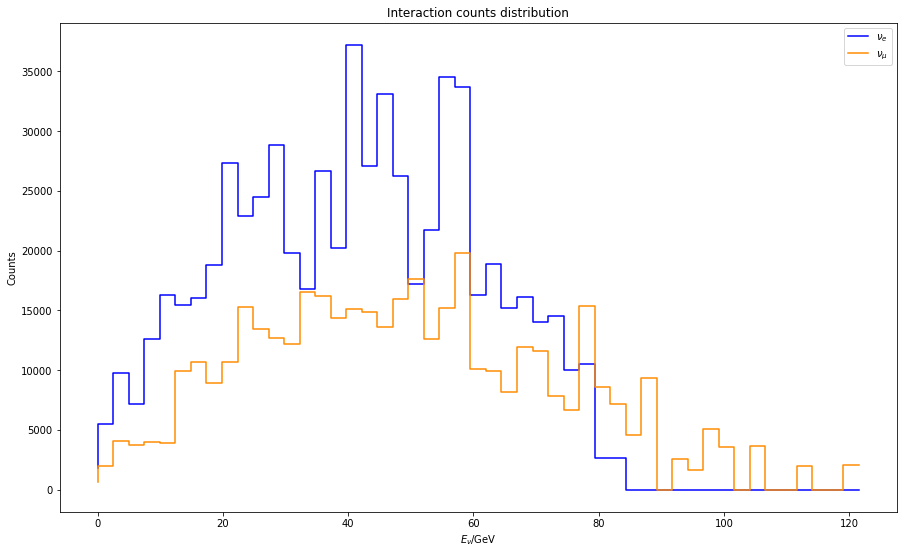

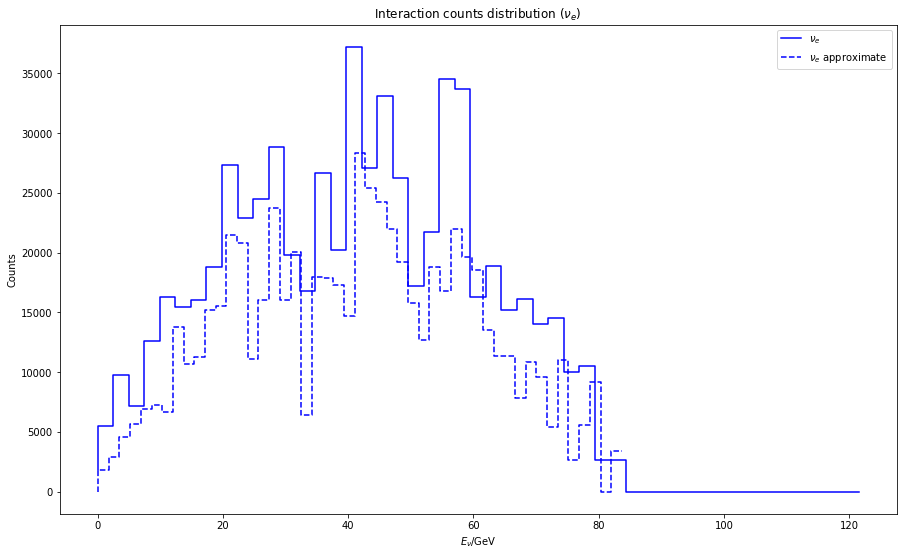

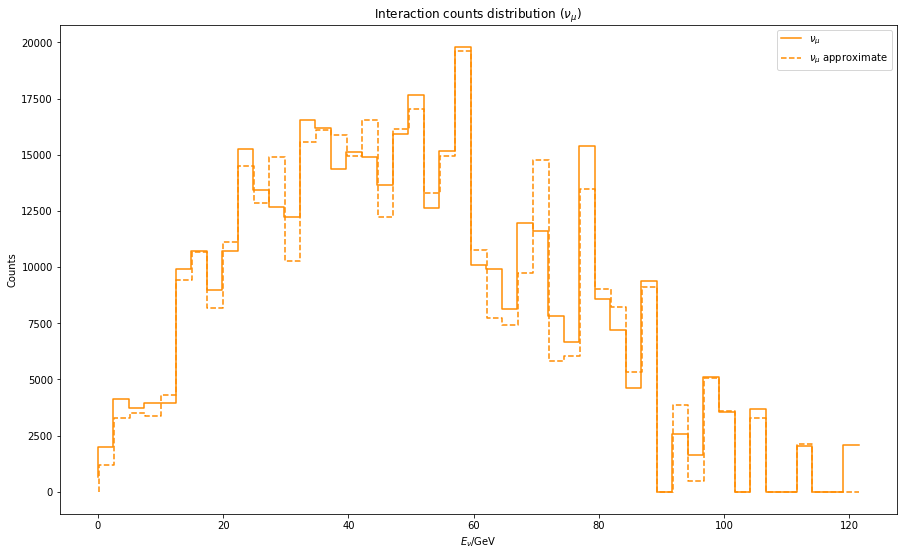

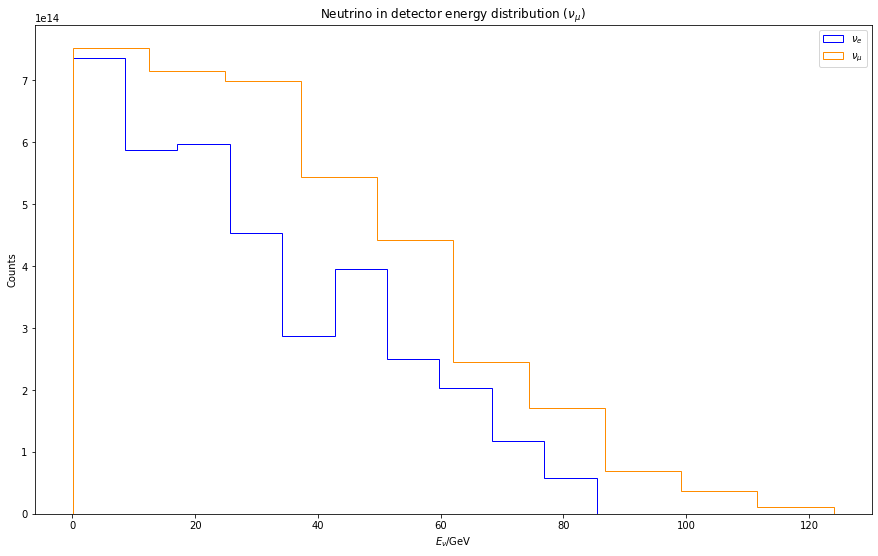

In [29]:
from nuflux import data
data.show_events(p0 = 1e2, p_max = 3e2, p_min = 0, RA =1e6, DH = 1e3, DD = [3e2,0], Nmu = 1e18, rho = 1.5, plots = True)